<a href="https://colab.research.google.com/github/Shujaat123/Ear_Biometrics/blob/main/IITD_Dataset_CustomModel(Paper)_EarBiometrics_with_dataAugmentation_SKv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
## Load useful packages
!pip install wget
!pip install py7zr

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# import keras
import py7zr
from zipfile import ZipFile
from random import sample

import PIL.Image as Image
from scipy import io
import matplotlib.pyplot as plt
from  sklearn.model_selection import train_test_split
from os import listdir
from os import path
import h5py
# import keras.backend as K
import tensorflow.keras.backend as K
import numpy as np
import wget
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [16]:
data_path = 'https://github.com/Alishba18001778/EarClassification/blob/main/IITD_Data_Tensor.mat?raw=true'
Data_filename = 'IITD_Data_Tensor.mat'

data_path_labels = 'https://github.com/Alishba18001778/EarClassification/blob/main/IITD_Labels.mat?raw=true'
labels_filename = 'IITD_Labels.mat'

if(path.exists(labels_filename)):
  !rm $labels_filename
  print('existing file:', labels_filename, ' has been deleted')
print('downloading latest version of file:', labels_filename)
wget.download(data_path_labels, labels_filename)

if(path.exists(Data_filename)):
  !rm $Data_filename
  print('existing file:', Data_filename, ' has been deleted')
print('downloading latest version of file:', Data_filename)
wget.download(data_path, Data_filename)
# 
u = io.loadmat('IITD_Data_Tensor.mat')
v = io.loadmat('IITD_Labels.mat')
sub_labels = v["sub_labels"]
sub_labels = np.squeeze(sub_labels.transpose())
ear_images = u["ear_images"]
ear_images = np.asarray(ear_images).astype('float32')

# sub_labels = to_categorical(np.array(sub_labels))
print(ear_images.shape)
print(sub_labels.shape)

existing file: IITD_Labels.mat  has been deleted
downloading latest version of file: IITD_Labels.mat
existing file: IITD_Data_Tensor.mat  has been deleted
downloading latest version of file: IITD_Data_Tensor.mat
(793, 180, 50)
(793,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(ear_images, sub_labels, test_size=0.382093316519, stratify=sub_labels, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(ear_images, sub_labels, test_size=0.7205, stratify=sub_labels, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(490, 180, 50)
(490,)
(303, 180, 50)
(303,)


In [18]:
## Functions for Augmentation 
import random

from scipy import ndimage

@tf.function(input_signature=[tf.TensorSpec((180,50), tf.float32)])
def rotate(volume):
  def scipy_rotate(volume):
    # define some rotation angles
    angles = [-5, -2.5, -1.25, 0, 1.25, 2.5, 5]
    # pick angles at random
    angle = random.choice(angles)
    angle = np.random.uniform(low=-5,high=5)
    # rotate volume
    volume = ndimage.rotate(volume, angle, reshape=False)
    volume[volume < 0] = 0
    volume[volume > 1] = 1
    return volume
    
  augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
  return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=2)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=2)
    return volume, label  

Dimension of the CT scan is: (180, 50, 1)


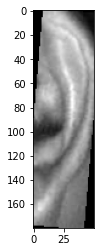

In [19]:
### Write Augmentation code here
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))

batch_size = 5
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(batch_size)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_test))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(batch_size)
)

import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :]), cmap="gray")

In [20]:
#Custom Model
def new_model():
  input_img = Input(shape=(180,50, 1))
  num_filter = 8
  kernel_size = 3
  strides = 1
  
  # input_zoomed =  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1)(input_img)
  # input_zoomed =  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1, 0.1)(input_zoomed)

  x = Conv2D(num_filter, kernel_size, strides, activation='relu',padding = 'same', name = 'enc1')(input_img)
  x = MaxPool2D((2, 2))(x)

    
  x = Conv2D(2*num_filter, kernel_size, strides, activation='relu', padding = 'same', name = 'enc3')(x) 
  x = BatchNormalization()(x)
  x = MaxPool2D((2, 2))(x)   
 
    
  x = Conv2D(4*num_filter, kernel_size, strides, activation='relu', padding = 'same', name = 'enc4')(x) 
  x = MaxPool2D((2, 2))(x) 

  x = Conv2D(8*num_filter, kernel_size, strides, activation='relu', padding = 'same', name = 'enc5')(x) 
  x = BatchNormalization()(x)
  x = MaxPool2D((2, 2))(x) 
  
  x = Conv2D(16*num_filter, kernel_size, strides, activation='relu', padding = 'same', name = 'enc6')(x) 
  x = MaxPool2D((2, 2))(x) 

  
  x = Conv2D(32*num_filter, kernel_size, strides, activation='relu', padding = 'same', name = 'enc7')(x) 
  x = BatchNormalization()(x)

  y = Flatten()(x) 

  output = Dense(221, activation='softmax')(y)

  Arch_pre = Model(input_img, output)
  
  Arch_pre.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  return Arch_pre

Arch_pre= new_model()
Arch_pre.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 180, 50, 1)]      0         
_________________________________________________________________
enc1 (Conv2D)                (None, 180, 50, 8)        80        
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 90, 25, 8)         0         
_________________________________________________________________
enc3 (Conv2D)                (None, 90, 25, 16)        1168      
_________________________________________________________________
batch_normalization_18 (Batc (None, 90, 25, 16)        64        
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 45, 12, 16)        0         
_________________________________________________________________
enc4 (Conv2D)                (None, 45, 12, 32)        4640

In [21]:
Arch_pre= new_model()
#Using the best model 
es = EarlyStopping(monitor='val_loss', patience=100, mode='min')
checkpoint = ModelCheckpoint('models\\modelweather-best.h5',
                                  verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

# Arch_pre.fit(X_train, y_train,
#                 epochs=100,
#                 batch_size=5,
#                 shuffle=True,
#                 validation_data=(X_test, y_test),
#                 callbacks = [es, checkpoint]
#                 )

Arch_pre.fit(train_dataset,
             validation_data=validation_dataset,
             epochs=100,
             callbacks = [es, checkpoint])

del Arch_pre  # deletes the existing model
Arch_pre = load_model('models\\modelweather-best.h5')

Epoch 1/100
98/98 [==============================] - 2s 16ms/step - loss: 6.4413 - accuracy: 0.0102 - val_loss: 5.8497 - val_accuracy: 0.0033
Epoch 2/100
98/98 [==============================] - 1s 12ms/step - loss: 5.1242 - accuracy: 0.0510 - val_loss: 6.9905 - val_accuracy: 0.0066
Epoch 3/100
98/98 [==============================] - 1s 12ms/step - loss: 3.9935 - accuracy: 0.1714 - val_loss: 7.9164 - val_accuracy: 0.0033
Epoch 4/100
98/98 [==============================] - 1s 12ms/step - loss: 2.5546 - accuracy: 0.3653 - val_loss: 7.8181 - val_accuracy: 0.0066
Epoch 5/100
98/98 [==============================] - 1s 12ms/step - loss: 1.2510 - accuracy: 0.7082 - val_loss: 4.6375 - val_accuracy: 0.0693
Epoch 6/100
98/98 [==============================] - 1s 12ms/step - loss: 0.5935 - accuracy: 0.8653 - val_loss: 1.5156 - val_accuracy: 0.6502
Epoch 7/100
98/98 [==============================] - 1s 12ms/step - loss: 0.3027 - accuracy: 0.9551 - val_loss: 1.4756 - val_accuracy: 0.6271
Epoch 

In [22]:
y_test_pred = Arch_pre.predict(X_test, batch_size=1, verbose=0)
acc = accuracy_score(y_test, y_test_pred.argmax(axis=1))

print('Test Accuracy: \t',acc)

Test Accuracy: 	 0.9306930693069307
